## Loading libraries 

In [7]:
%matplotlib inline


from __future__ import division, print_function
import os, json
from glob import glob 
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots


Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [5]:
path = "../data/dogscats"
#path = "./data/dogscats/sample"
os.listdir(path)

['valid', 'sample', 'train', 'test1', 'models']

## Part 1  

Using Vgg16 - custom model in 7 lines of code

In [8]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16
batch_size = 64 
vgg=Vgg16()

In [12]:
batches = vgg.get_batches(path + '/train', batch_size= batch_size)
val_batches = vgg.get_batches(path + '/valid', batch_size = batch_size)
vgg.finetune(batches)
vgg.fit(batches,val_batches,nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 615s - loss: 0.2124 - acc: 0.9572 - val_loss: 0.0944 - val_acc: 0.9810

## Part 2

Vgg16 for basic image 

just change to two classes. 

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 23000 images belonging to 2 classes.


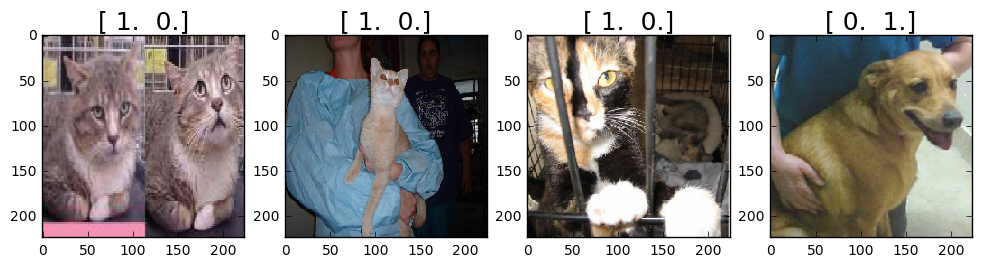

In [15]:
vgg = Vgg16()
batches = vgg.get_batches(path+'/train', batch_size = 4)

## for fun 
imgs,labels = next(batches)
plots(imgs,titles= labels)
## 

In [17]:
vgg.predict(imgs,True) #predict 

(array([ 0.8683,  0.3052,  0.6313,  0.1681], dtype=float32),
 array([287, 151, 281, 273]),
 [u'lynx', u'Chihuahua', u'tabby', u'dingo'])

In [18]:
vgg.classes[:10] #showing the classes 

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

## Part 3 

use Vgg to finetune a Dogs Vs Cats Model (Not running because it is the same as part 1)

In [19]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()
batch_size = 64 
batches = vgg.get_batches(path+'/train', batch_size = batch_size)
val_batches = vgg.get_batches(path + '/valid', batch_size = batch_size)
vgg.finetune(batches)
#vgg.fit(batches,val_batches, nb_epoch =1)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Part 4 

Training Vgg model from start 

In [20]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [21]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [22]:
classes[:10]

[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

Defining model creation 

In [23]:
#Convolutional layer 
def Convblock(layers,model,filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters,3,3,activation='relu'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    
#fully connected layer 
def FCblock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [33]:
#subtract the image by the mean and reshape it.
#also, change the BGR order to RGB 

vgg_mean = np.array([123.68, 116.779,103.939]).reshape((3,1,1)) 
print(vgg_mean)

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:,::-1] #reverse axis bgr -> rgb 

[[[ 123.68 ]]

 [[ 116.779]]

 [[ 103.939]]]


In [48]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3,224,224)))
    
    Convblock(2,model,64)
    Convblock(2,model,128)
    Convblock(3,model,256)
    Convblock(3,model,512)
    Convblock(3,model,512)
    
    model.add(Flatten())
    FCblock(model)
    FCblock(model)
    model.add(Dense(1000,activation='softmax'))
    return model

In [49]:
model = VGG_16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [50]:
#load the pre-train weights

fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)


Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


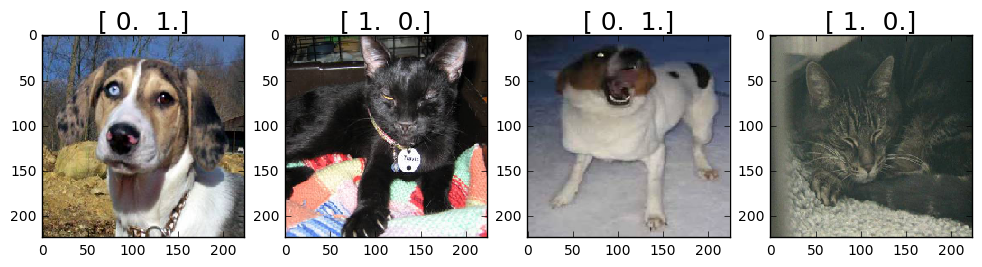

In [54]:
## Getting imagenet predictions 
batch_size = 4 

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches('/train', batch_size = batch_size)
val_batches = get_batches('/valid', batch_size = batch_size)

imgs,labels = next(batches)
plots(imgs, titles=labels)

In [56]:
preds = model.predict(imgs)
print(preds)

[[  1.7144e-06   2.8323e-07   3.0643e-07 ...,   1.5324e-06   1.0848e-05   1.7987e-05]
 [  2.2925e-09   1.3536e-07   3.6897e-08 ...,   7.3229e-10   4.9547e-06   1.0372e-03]
 [  7.4419e-06   5.6579e-06   1.7761e-06 ...,   2.6593e-06   3.3470e-05   5.6515e-03]
 [  3.6737e-06   3.1247e-05   6.8315e-06 ...,   8.3911e-07   3.6735e-05   1.1843e-03]]


In [57]:
print(preds.shape) #4 predictions of 1000 classes each

(4, 1000)


In [59]:
idxs = np.argmax(preds, axis=1)
print(idxs)
for i in range(len(idxs)):
    idx = idxs[i]
    print('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

[166 223 158 281]
  0.3645/Walker_hound
  0.8308/schipperke
  0.2631/toy_terrier
  0.7021/tabby
